# Resting EEG

Design:

* 3 minute recording
* eyes open vs. eyes closed


Data format: `mkpy.mkh5` HDF5

The mkpy.mkh5 data file `s000eeg.h5` is a single HDF5 file with four HDF5 groups, each group has one HDF5 dataset, _dblock_0_, the uninterrupted EEG recording. 

    /open
    /closed
    /cals_AD_before
    /cals_10uV_after

In longer experimental sessions where the recording is paused from time to time, the data group spans multiple, sequentially labeled data blocks, _dblock_0, dblock_1, ... \dblock_n_, each an uninterrupted recording.

The A/D EEG recordings are converted to a $\mu\mathrm{V}$ scale via the (mean) $10\mu\mathrm{V}$ square wave. The calibration pulses are recorded in `.crw`, and `.log` files are read and converted to HDF5 the same way as EEG data files. Calibration data are typically recorded for each experimental session, so by default each data group is scanned for a dblock with calibration pulses. However since these EEG recordings are from the same session, a single calibration data can be re-used for the different data groups as shown below.

**Example 1** shows how to read the read the HDF5 header and EEG recordings into a pandas.DataFrame with mkpy.

**Example 2** shows the contents of the data block headers including sensor location coordinates.

**Example 3** shows how to read the HDF5 dblock header and numpy structured array EEG data directly with h5py.

In [1]:
import os
import sys
from pathlib import Path
import re
import numpy as np
import pandas as pd
import mkpy
import spudtr

from matplotlib import pyplot as plt
from mkpy import mkh5
from spudtr import epf

# path wrangling for nbsphinx
if "MDE_HOME" in os.environ.keys():
    MDE_HOME = Path(os.environ["MDE_HOME"])
else:
    from conf import MDE_HOME
DOCS_DATA = MDE_HOME / "docs/_data"
print(os.environ["CONDA_DEFAULT_ENV"])
print(sys.version)
for pkg in [np, pd, mkpy, spudtr]:
    print(pkg.__name__, pkg.__version__, pkg.__file__)

mkconda_dev_py39_053022
3.9.13 | packaged by conda-forge | (main, May 27 2022, 16:56:21) 
[GCC 10.3.0]
numpy 1.21.6 /home/turbach/miniconda39/envs/mkconda_dev_py39_053022/lib/python3.9/site-packages/numpy/__init__.py
pandas 1.1.5 /home/turbach/miniconda39/envs/mkconda_dev_py39_053022/lib/python3.9/site-packages/pandas/__init__.py
mkpy 0.2.7 /mnt/cube/home/turbach/TPU_Projects/mkpy/mkpy/__init__.py
spudtr 0.1.0 /home/turbach/miniconda39/envs/mkconda_dev_py39_053022/lib/python3.9/site-packages/spudtr/__init__.py


**Convert and calibrate the `.crw`, `.log` to mkpy.mkh5 format HDF5**


Notes: 

* only A/D cals are needed for calibration, the 10 uV copy is just for illustration.
* the negative event code warning is expected and signals the the pause mark at the end of the recording

In [2]:
# 1. set the fileHDF5 file and load the EEG data
eeg_h5_f = DOCS_DATA / "sub000eeg.h5"  
eeg_h5 = mkh5.mkh5(eeg_h5_f)  # wipe previous
eeg_h5.reset_all()  # wipe previous

for h5_group in ["open", "closed"]:
    crw = MDE_HOME / f"mkdig/sub000r{h5_group[0]}.crw"    # resting EEG eyes open
    log = MDE_HOME / f"mkdig/sub000r{h5_group[0]}.x.log"  # events 
    yhdr = MDE_HOME / f"mkpy/sub000r{h5_group[0]}.yhdr"   # extra header info
    
    # eyes open, closed EEG data sets
    eeg_h5.create_mkdata(h5_group, crw, log, yhdr)

# 2. set calibration pulse parameters and files
pts, pulse, lo, hi, ccode = 5, 10, -40, 40, 0

cals_crw = MDE_HOME / "mkdig/sub000c.crw"
cals_log = MDE_HOME / "mkdig/sub000c.x.log"
cals_yhdr = MDE_HOME / "mkpy/sub000c.yhdr"

#  A/D square wave cal data are needed for calibration
eeg_h5.create_mkdata("cals_AD_before", cals_crw, cals_log, cals_yhdr)

# this copy is scaled as if EEG data for illustration only
eeg_h5.create_mkdata("cals_10uV_after", cals_crw, cals_log, cals_yhdr)

for h5_group in ["open", "closed", "cals_10uV_after"]:

    eeg_h5.calibrate_mkdata(
        h5_group,  # data group to calibrate with these cal pulses
        n_points=pts,  # pts to average
        cal_size=pulse,  # uV
        lo_cursor=lo,  # lo_cursor ms
        hi_cursor=hi,  # hi_cursor ms
        cal_ccode=ccode,  # condition code
        use_cals="cals_AD_before"  # alternate data group to find calibration pulses
    )

print("\n" * 2)
print("These are the HDF5 datasets in the HDF5 file")
dblock_paths = eeg_h5.dblock_paths

display(dblock_paths)

/mnt/cube/home/turbach/TPU_Projects/mkpy/mkpy/mkh5.py:3666: UserWarning: negative event code(s) found for cal condition code 0 -16384
  warnings.warn(msg)


Found cals in /cals_AD_before/dblock_0
Calibrating block /open/dblock_0 of 1: (45568,)  


Found cals in /cals_AD_before/dblock_0
Calibrating block /closed/dblock_0 of 1: (45568,)  


Found cals in /cals_AD_before/dblock_0
Calibrating block /cals_10uV_after/dblock_0 of 1: (28416,)  





These are the HDF5 datasets in the HDF5 file


['cals_10uV_after/dblock_0',
 'cals_AD_before/dblock_0',
 'closed/dblock_0',
 'open/dblock_0']

**Example 1. importing mkh5 EEG recordings into a pandas.DataFrame with mkpy**

In [3]:
dblocks = list()
hdrs = list()
for dbp in dblock_paths:
    
    # hdr is a large dict() that includes sample rate and sensor locations among other things
    # dblock is a 1-D numpy structured array (named numeric dtypes): samples (rows) x data streams (columns)
    hdr, dblock = eeg_h5.get_dblock(dbp)

    # sanity check the fully qualified HDF5 root path /group/dblock_0 
    # as logged in the header when the data were converted
    assert dbp == hdr["h5_dataset"][1:]
    
    # convert to dataframe and track the dblock sequence
    dblock = pd.DataFrame(dblock)
    dblock.insert(0, "dblock_path", dbp)
    
    #(optional) grab useful info from the header
    dblock.insert(0, "sub_id", hdr["runsheet"]["subid"])
    
    # capture
    dblocks.append(dblock)
    hdrs.append(hdr)
    
eeg_pd = pd.concat(dblocks)
display(eeg_pd)

,sub_id,dblock_path,dblock_ticks,crw_ticks,raw_evcodes,log_evcodes,log_ccodes,log_flags,pygarv,lle,...,RMOc,LLTe,RLTe,LLOc,RLOc,MiOc,A2,HEOG,rle,rhz
0,demonstration,cals_10uV_after/dblock_0,0,0,0,0,0,0,0,0.000000,...,-0.737793,0.251221,0.493408,-0.248413,-0.245972,-0.242920,0.000000,0.000000,0.000000,0.000000
1,demonstration,cals_10uV_after/dblock_0,1,1,0,0,0,0,0,0.000000,...,-1.229492,0.000000,0.000000,-0.248413,-0.245972,-0.242920,-0.492188,0.000000,-0.487549,0.000000
2,demonstration,cals_10uV_after/dblock_0,2,2,0,0,0,0,0,0.000000,...,-0.245972,0.502441,0.246704,0.000000,-0.245972,-0.242920,0.000000,0.489502,0.000000,0.485840
3,demonstration,cals_10uV_after/dblock_0,3,3,0,0,0,0,0,0.000000,...,0.000000,0.000000,0.246704,0.248413,-0.245972,-0.242920,-0.246094,0.244751,0.000000,0.000000
4,demonstration,cals_10uV_after/dblock_0,4,4,0,0,0,0,0,0.000000,...,-0.245972,0.251221,0.493408,0.000000,-0.245972,0.000000,0.000000,0.489502,0.000000,0.485840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45563,demonstration,open/dblock_0,45563,45563,0,0,0,0,0,-5.105469,...,7.132812,0.753906,-2.712891,7.949219,-1.475586,7.289062,-2.214844,-15.906250,10.242188,-0.485840
45564,demonstration,open/dblock_0,45564,45564,0,0,0,0,0,6.808594,...,3.197266,-4.523438,-8.390625,6.210938,-5.656250,5.101562,-9.593750,-23.000000,1.950195,-5.343750
45565,demonstration,open/dblock_0,45565,45565,0,0,0,0,0,11.914062,...,5.902344,0.251221,-4.687500,10.187500,-3.197266,8.015625,-4.183594,-31.328125,6.339844,-6.316406
45566,demonstration,open/dblock_0,45566,45566,0,0,0,0,0,4.539062,...,4.671875,8.039062,-6.414062,7.949219,-2.705078,8.742188,-1.722656,-22.265625,17.062500,-0.971680


Note the applying the calibration routine to the A/D calibration pulses scales the to $10 \mu\mathrm{V}$.

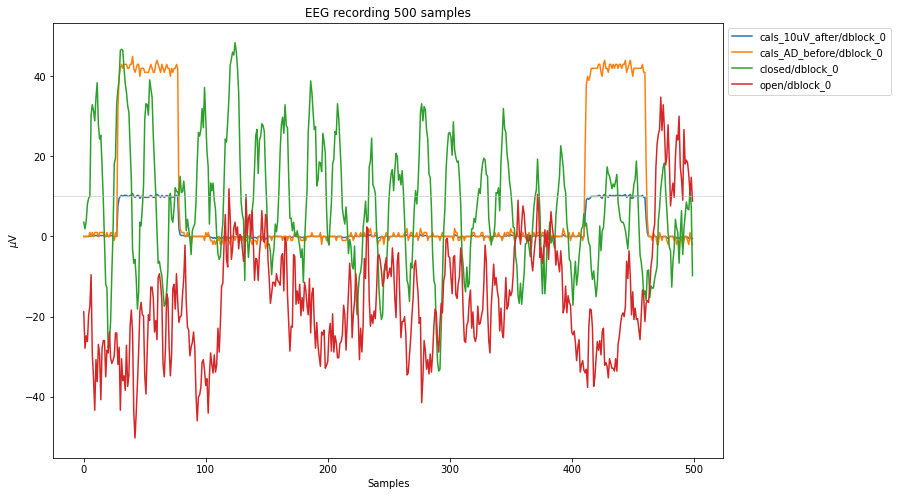

In [4]:
#import matplotlib as mpl
with plt.style.context({"font.size": 18}):
    f, ax = plt.subplots(figsize=(12, 8))
    for dblock_path, dblock_data in eeg_pd.groupby("dblock_path"):
        dblock_data["MiPa"][0:500].plot(label=dblock_path, ax=ax)
        ax.axhline(10, color='lightgray', lw=.5, alpha=.6)
        ax.set(xlabel= "Samples", ylabel="$\mu\mathrm{V}$")
        ax.set_title("EEG recording 500 samples")
        ax.legend(bbox_to_anchor=(1,1))

**Example 2: dblock headers**

In [5]:
eeg_hdrs = dict([(hdr["h5_dataset"], hdr) for hdr in hdrs])
display(eeg_hdrs.keys())
display(eeg_hdrs["/closed/dblock_0"])

dict_keys(['/cals_10uV_after/dblock_0', '/cals_AD_before/dblock_0', '/closed/dblock_0', '/open/dblock_0'])

{'runsheet': {'name': 'runsheet',
  'experiment': 'resting EEG eyes closed',
  'subid': 'demonstration',
  'date': '08-22-2018',
  'hand': 'LRRL',
  'license': 'Creative Commons Attribution-NonCommercial-ShareAlike (CC BY-NC-SA) 4.0',
  'notes': 'These EEG recordings were made for instructional purposes and are not human subjects research data. This work is licensed under a Creative Commons Attribution-NonCommercial-ShareAlike 4.0 International License. https://creativecommons.org/licenses/by-nc-sa/4.0/legalcode'},
 'apparatus': {'name': 'apparatus',
  'mne_montage_name': '26chan',
  'common_ref': 'A1',
  'gain20K': 20000,
  'gain10K': 10000,
  'lp': 100.0,
  'hp': 0.01,
  'streams': {'lle': {'pos': 'lle',
    'neg': 'A1',
    'gain': 10000,
    'hphz': 0.01,
    'lphz': 100.0,
    'mne_type': 'eeg'},
   'lhz': {'pos': 'lhz',
    'neg': 'A1',
    'gain': 10000,
    'hphz': 0.01,
    'lphz': 100.0,
    'mne_type': 'eeg'},
   'MiPf': {'pos': 'MiPf',
    'neg': 'A1',
    'gain': 10000,
  

**Example 3: reading EEG and headers without mkpy**

WARNING: using a context manager with h5py is strongly advised.

In [6]:
import pprint as pp
import json
import h5py

eeg_h5_f = MDE_HOME / f"data/sub000eeg.h5"  

json_hdrs = list()
np_dblocks = list()

with h5py.File(eeg_h5_f, 'r') as h5:
    for group_path, group in h5.items():
        for dblock_path, dblock in group.items():
            json_hdrs.append(json.loads(dblock.attrs["json_header"]))
            np_dblocks.append(dblock[...].copy())

print("1-D numpy structured array, samples (rows) x data streams (columns), compound dtype")
display(np_dblocks[0].shape, np_dblocks[0].dtype)

print()
print("\n", "header dicts from HDF5 dataset attribute json stringj")
pp.pprint(json_hdrs[0].keys())

1-D numpy structured array, samples (rows) x data streams (columns), compound dtype


(28416,)

dtype([('dblock_ticks', '<u4'), ('crw_ticks', '<u4'), ('raw_evcodes', '<i2'), ('log_evcodes', '<i2'), ('log_ccodes', '<u2'), ('log_flags', '<u2'), ('pygarv', '<u8'), ('lle', '<f2'), ('lhz', '<f2'), ('MiPf', '<f2'), ('LLPf', '<f2'), ('RLPf', '<f2'), ('LMPf', '<f2'), ('RMPf', '<f2'), ('LDFr', '<f2'), ('RDFr', '<f2'), ('LLFr', '<f2'), ('RLFr', '<f2'), ('LMFr', '<f2'), ('RMFr', '<f2'), ('LMCe', '<f2'), ('RMCe', '<f2'), ('MiCe', '<f2'), ('MiPa', '<f2'), ('LDCe', '<f2'), ('RDCe', '<f2'), ('LDPa', '<f2'), ('RDPa', '<f2'), ('LMOc', '<f2'), ('RMOc', '<f2'), ('LLTe', '<f2'), ('RLTe', '<f2'), ('LLOc', '<f2'), ('RLOc', '<f2'), ('MiOc', '<f2'), ('A2', '<f2'), ('HEOG', '<f2'), ('rle', '<f2'), ('rhz', '<f2')])



 header dicts from HDF5 dataset attribute json stringj
dict_keys(['runsheet', 'apparatus', 'yhdr_file', 'yhdr_file_md5', 'streams', 'name', 'magic', 'subdesc', 'expdesc', 'odelay', 'samplerate', 'recordduration', 'recordsize', 'nrawrecs', 'nchans', 'mkh5_version', 'raw_dig_header', 'eeg_file', 'eeg_file_stat', 'log_file', 'uuid', 'eeg_file_md5', 'log_file_md5', 'h5_dataset'])
